In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import PrecisionRecallDisplay, precision_recall_curve, average_precision_score
import numpy as np
from scipy.stats import wasserstein_distance
from tqdm import tqdm
import pickle

In [2]:
!free -h

              total        used        free      shared  buff/cache   available
Mem:          503Gi       7.1Gi       429Gi       1.9Gi        66Gi       490Gi
Swap:         4.0Gi        18Mi       4.0Gi


In [3]:
def get_top_k(y_true, y_pred):
    idx_true = np.nonzero(y_true == 1)[0]
    argsorted_y_pred = np.argsort(y_pred)
    sorted_y_pred = np.sort(y_pred)

    topkl_accuracy = []
    threshold = []
    top_length = 1
    idx_pred = argsorted_y_pred[-int(top_length*len(idx_true)):]
    correct = np.size(np.intersect1d(idx_true, idx_pred))
    total = float(min(len(idx_pred), len(idx_true)))
    if top_length == 1:
        correct_1 = correct
        total_1 = total
    topkl_accuracy += [ correct/ total]
    threshold += [sorted_y_pred[-int(top_length*len(idx_true))]]
    return topkl_accuracy,threshold

In [4]:
df1 = pd.read_csv('/odinn/tmp/benediktj/Data/SplicePrediction-050422/spliceai_10k_test_set_predictions_191022.gz')
df2 = pd.read_csv('/odinn/tmp/benediktj/Data/SplicePrediction-050422/transformer_40k_test_set_predictions_191022.gz')

In [5]:
get_top_k(df1.Y_true_acceptor.values, df1.Y_pred_acceptor.values)

([0.9369092206170858], [0.45983067])

In [6]:
get_top_k(df1.Y_true_donor.values, df1.Y_pred_donor.values)

([0.9418695380774033], [0.50665945])

In [7]:
get_top_k(df2.Y_true_acceptor.values, df2.Y_pred_acceptor.values)

([0.9410335295166756], [0.44630966])

In [8]:
get_top_k(df2.Y_true_donor.values, df2.Y_pred_donor.values)

([0.9460384341002318], [0.4851531])

In [9]:
a1 = (df1['Y_pred_acceptor']>=0.45983067).astype(int).values
d1 = (df1['Y_pred_donor']>=0.50665945).astype(int).values
a2 = (df2['Y_pred_acceptor']>=0.44630966).astype(int).values
d2 = (df2['Y_pred_donor']>=0.4851531).astype(int).values

In [10]:
true_splice = (df1.Y_true_acceptor+df1.Y_true_donor).values>0

In [11]:
print(np.sum((a1+d1)[true_splice]==(a2+d2)[true_splice]))
print(np.sum((a1+d1)[~true_splice]==(a2+d2)[~true_splice]))
print(np.sum((a1+d1)[true_splice]!=(a2+d2)[true_splice]))
print(np.sum((a1+d1)[~true_splice]!=(a2+d2)[~true_splice]))

175825
664757322
3599
3254


In [12]:
agree = (a1+d1)==(a2+d2)
disagree = (a1+d1)!=(a2+d2)

In [13]:
print(np.mean((a1+d1)[agree]==true_splice.astype(int)[agree]))
print(np.mean((a2+d2)[agree]==true_splice.astype(int)[agree]))
print(np.mean((a1+d1)[disagree]==true_splice.astype(int)[disagree]))
print(np.mean((a2+d2)[disagree]==true_splice.astype(int)[disagree]))

0.9999735612518652
0.9999735612518652
0.39121552604698673
0.6087844739530133


In [14]:
print(np.sum((a1+d1)[agree]==true_splice.astype(int)[agree]))
print(np.sum((a2+d2)[agree]==true_splice.astype(int)[agree]))
print(np.sum((a1+d1)[disagree]==true_splice.astype(int)[disagree]))
print(np.sum((a2+d2)[disagree]==true_splice.astype(int)[disagree]))

664915567
664915567
2681
4172


In [15]:
wrong1 = (a1+d1)[disagree]!=true_splice.astype(int)[disagree]
wrong2 = (a2+d2)[disagree]!=true_splice.astype(int)[disagree]

In [16]:
print(np.mean((a1+d1)[disagree][wrong2]==true_splice.astype(int)[disagree][wrong2]))
print(np.mean((a2+d2)[disagree][wrong1]==true_splice.astype(int)[disagree][wrong1]))

1.0
1.0


In [17]:
print(np.sum((a1+d1)[disagree][wrong2]==true_splice.astype(int)[disagree][wrong2]))
print(np.sum((a2+d2)[disagree][wrong1]==true_splice.astype(int)[disagree][wrong1]))

2681
4172


In [18]:
wrong1 = (a1+d1)!=true_splice.astype(int)
wrong2 = (a2+d2)!=true_splice.astype(int)

In [19]:
print(np.mean((a1+d1)[wrong2]==true_splice.astype(int)[wrong2]))
print(np.mean((a2+d2)[wrong1]==true_splice.astype(int)[wrong1]))

0.13232318246878239
0.19179845531445383


In [20]:
print(np.sum((a1+d1)[wrong2]==true_splice.astype(int)[wrong2]))
print(np.sum((a2+d2)[wrong1]==true_splice.astype(int)[wrong1]))

2681
4172


In [21]:
p1 = np.vstack([1-(df1.Y_pred_acceptor.values+df1.Y_pred_donor.values),df1.Y_pred_acceptor.values,df1.Y_pred_donor.values])

In [22]:
p2 = np.vstack([1-(df2.Y_pred_acceptor.values+df2.Y_pred_donor.values),df2.Y_pred_acceptor.values,df2.Y_pred_donor.values])

In [22]:
def tvd(x,y):
    return np.sum(np.absolute(x-y))/2

In [7]:
import multiprocessing
from joblib import Parallel, delayed

def get_tvd(i):
    return tvd(p1[:,i],p2[:,i])

num_cores = multiprocessing.cpu_count()
inputs = tqdm(range(df1.shape[0]))

tv_dist = Parallel(n_jobs=num_cores)(delayed(get_tvd)(i) for i in inputs)

100%|███████████████████████████████████████████████████████████████████████████████████████| 664940000/664940000 [18:00:26<00:00, 10257.23it/s]


In [8]:
#w_dist = [wasserstein_distance(p1[:,i],p2[:,i]) for i in tqdm(range(df1.shape[0]))]
#with open('/odinn/tmp/benediktj/Data/SplicePrediction-050422/tvd-191022.pkl', 'wb') as f:
#    pickle.dump(tv_dist, f)

In [5]:
with open('/odinn/tmp/benediktj/Data/SplicePrediction-050422/tvd-191022.pkl', 'rb') as f:
    tv_dist = pickle.load(f)

In [6]:
df1['tvd'] = tv_dist
df2['tvd'] = tv_dist

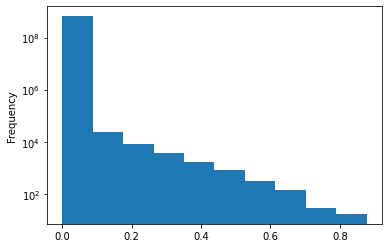

In [7]:
df1['tvd'].plot(kind="hist", logy=True)
plt.show()

In [8]:
df1_da = df1[df1['tvd']>=0.1]
df2_da = df2[df2['tvd']>=0.1]

In [9]:
df1.shape

(664940000, 5)

In [10]:
df1_da

,Y_true_acceptor,Y_pred_acceptor,Y_true_donor,Y_pred_donor,tvd
618,0.0,0.000013,0.0,0.158448,0.154366
847,0.0,0.000006,1.0,0.030055,0.130592
1529,1.0,0.142483,0.0,0.000069,0.220496
7787,0.0,0.486372,0.0,0.000659,0.204072
10286,0.0,0.000024,1.0,0.962563,0.108739
...,...,...,...,...,...
664918411,0.0,0.000005,0.0,0.001985,0.120389
664929716,0.0,0.000138,1.0,0.685981,0.194253
664936354,0.0,0.211327,0.0,0.000171,0.199835
664937376,1.0,0.670814,0.0,0.000246,0.170243


In [11]:
df2_da

,Y_true_acceptor,Y_pred_acceptor,Y_true_donor,Y_pred_donor,tvd
618,0.0,0.000462,0.0,0.312366,0.154366
847,0.0,0.000227,1.0,0.160425,0.130592
1529,1.0,0.362243,0.0,0.000804,0.220496
7787,0.0,0.282691,0.0,0.000269,0.204072
10286,0.0,0.000071,1.0,0.853824,0.108739
...,...,...,...,...,...
664918411,0.0,0.000094,0.0,0.122285,0.120389
664929716,0.0,0.000224,1.0,0.880148,0.194253
664936354,0.0,0.011583,0.0,0.000079,0.199835
664937376,1.0,0.500571,0.0,0.000268,0.170243


In [12]:
df1_da[df1_da['Y_true_acceptor']==1]['Y_pred_acceptor']

1529         0.142483
26768        0.694114
28520        0.978176
39184        0.804585
49189        0.804585
               ...   
664522806    0.443494
664649379    0.731782
664774809    0.413575
664937376    0.670814
664938867    0.144983
Name: Y_pred_acceptor, Length: 8323, dtype: float64

In [13]:
df2_da[df2_da['Y_true_acceptor']==1]

,Y_true_acceptor,Y_pred_acceptor,Y_true_donor,Y_pred_donor,tvd
1529,1.0,0.362243,0.0,0.000804,0.220496
26768,1.0,0.529221,0.0,0.000394,0.164893
28520,1.0,0.870622,0.0,0.000055,0.107554
39184,1.0,0.928085,0.0,0.000026,0.123520
49189,1.0,0.937426,0.0,0.000024,0.132860
...,...,...,...,...,...
664522806,1.0,0.685062,0.0,0.000536,0.241567
664649379,1.0,0.395998,0.0,0.000072,0.335783
664774809,1.0,0.274319,0.0,0.000195,0.139255
664937376,1.0,0.500571,0.0,0.000268,0.170243


In [14]:
df1_da[df1_da['Y_true_donor']==1]

,Y_true_acceptor,Y_pred_acceptor,Y_true_donor,Y_pred_donor,tvd
847,0.0,0.000006,1.0,0.030055,0.130592
10286,0.0,0.000024,1.0,0.962563,0.108739
19233,0.0,0.000097,1.0,0.753646,0.215132
39256,0.0,0.000005,1.0,0.633261,0.168520
42862,0.0,0.000012,1.0,0.800534,0.168339
...,...,...,...,...,...
664696370,0.0,0.000326,1.0,0.876987,0.545888
664700094,0.0,0.000309,1.0,0.975707,0.109532
664773024,0.0,0.000057,1.0,0.866844,0.126281
664827288,0.0,0.000141,1.0,0.726537,0.324782


In [15]:
df2_da[df2_da['Y_true_donor']==1]

,Y_true_acceptor,Y_pred_acceptor,Y_true_donor,Y_pred_donor,tvd
847,0.0,0.000227,1.0,0.160425,0.130592
10286,0.0,0.000071,1.0,0.853824,0.108739
19233,0.0,0.000140,1.0,0.968736,0.215132
39256,0.0,0.000074,1.0,0.801712,0.168520
42862,0.0,0.000135,1.0,0.968750,0.168339
...,...,...,...,...,...
664696370,0.0,0.000281,1.0,0.331143,0.545888
664700094,0.0,0.000639,1.0,0.866175,0.109532
664773024,0.0,0.000265,1.0,0.740563,0.126281
664827288,0.0,0.000204,1.0,0.401755,0.324782


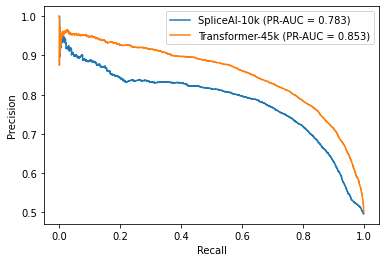

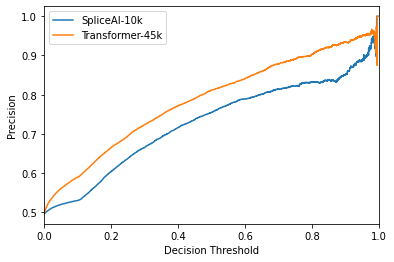

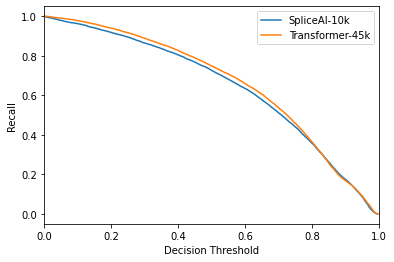

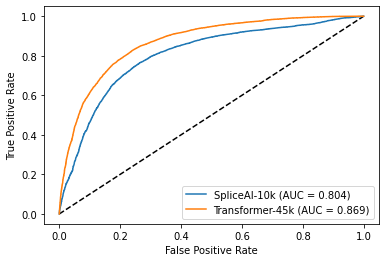

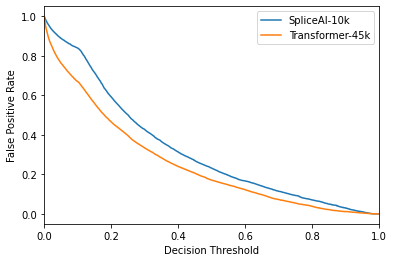

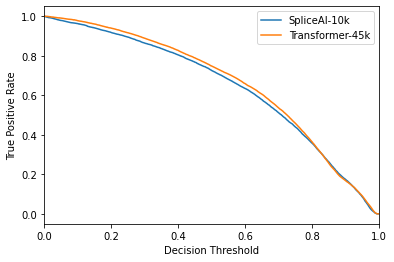

In [21]:
precision1, recall1, thresholds1 = precision_recall_curve(df1_da.Y_true_acceptor+df1_da.Y_true_donor, df1_da.Y_pred_acceptor+df1_da.Y_pred_donor)
precision2, recall2, thresholds2 = precision_recall_curve(df2_da.Y_true_acceptor+df2_da.Y_true_donor, df2_da.Y_pred_acceptor+df2_da.Y_pred_donor)
ap1 = average_precision_score(df1_da.Y_true_acceptor+df1_da.Y_true_donor, df1_da.Y_pred_acceptor+df1_da.Y_pred_donor)
ap2 = average_precision_score(df2_da.Y_true_acceptor+df2_da.Y_true_donor, df2_da.Y_pred_acceptor+df2_da.Y_pred_donor)

plt.plot(recall1,precision1,label="SpliceAI-10k (PR-AUC = {})".format(np.round(ap1,3)))
plt.plot(recall2,precision2,label="Transformer-45k (PR-AUC = {})".format(np.round(ap2,3)))
plt.legend()
plt.xlabel('Recall')
plt.ylabel('Precision')

plt.savefig('../Results/PRC_disagreement_171023.png', dpi=300)
plt.show()
plt.plot(thresholds1,precision1[:-1],label="SpliceAI-10k")
plt.plot(thresholds2,precision2[:-1],label="Transformer-45k")
plt.legend()
plt.xlim(0,1)
plt.ylabel('Precision')
plt.xlabel('Decision Threshold')
plt.savefig('../Results/Precision_Decision_Threshold_disagreement_171023.png', dpi=300)
plt.show()
plt.plot(thresholds1,recall1[:-1],label="SpliceAI-10k")
plt.plot(thresholds2,recall2[:-1],label="Transformer-45k")
plt.legend()
plt.xlim(0,1)
plt.ylabel('Recall')
plt.xlabel('Decision Threshold')
plt.savefig('../Results/Recall_Decision_Threshold_disagreement_171023.png', dpi=300)
plt.show()


pd.DataFrame({'Threshold': thresholds1, 'SpliceAI-10k-recall': recall1[:-1], 'SpliceAI-10k-precision': precision1[:-1]}).to_csv('../Results/figure_1_c_prc_SpliceAI-10k.csv', index=False)
pd.DataFrame({'Threshold': thresholds2,'Transformer-45k-recall': recall2[:-1], 'Transformer-45k-precision': precision2[:-1]}).to_csv('../Results/figure_1_c_prc_Transformer-45k.csv', index=False)

from sklearn.metrics import roc_curve, auc
fpr1, tpr1, thresholds1 = roc_curve(df1_da.Y_true_acceptor+df1_da.Y_true_donor, df1_da.Y_pred_acceptor+df1_da.Y_pred_donor)
fpr2, tpr2, thresholds2 = roc_curve(df2_da.Y_true_acceptor+df2_da.Y_true_donor, df2_da.Y_pred_acceptor+df2_da.Y_pred_donor)
auc1 = auc(fpr1, tpr1)
auc2 = auc(fpr2, tpr2)

plt.plot([0, 1], [0, 1], "k--")
plt.plot(fpr1,tpr1,label="SpliceAI-10k (AUC = {})".format(np.round(auc1,3)))
plt.plot(fpr2,tpr2,label="Transformer-45k (AUC = {})".format(np.round(auc2,3)))
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.savefig('../Results/ROC_disagreement_171023.png', dpi=300)
plt.show()

#plt.plot([0, 1], [0, 1], "k--")
plt.plot(thresholds1,fpr1,label="SpliceAI-10k")
plt.plot(thresholds2,fpr2,label="Transformer-45k")
plt.legend()
plt.xlim(0,1)
plt.ylabel('False Positive Rate')
plt.xlabel('Decision Threshold')
plt.savefig('../Results/FPR_Decision_Threshold_disagreement_171023.png', dpi=300)
plt.show()

plt.plot(thresholds1,tpr1,label="SpliceAI-10k")
plt.plot(thresholds2,tpr2,label="Transformer-45k")
plt.legend()
plt.xlim(0,1)
plt.ylabel('True Positive Rate')
plt.xlabel('Decision Threshold')
plt.savefig('../Results/TPR_Decision_Threshold_disagreement_171023.png', dpi=300)
plt.show()

pd.DataFrame({'Threshold': thresholds1, 'SpliceAI-10k-fpr': fpr1, 'SpliceAI-10k-tpr': tpr1}).to_csv('../Results/figure_1_c_d_roc_SpliceAI-10k.csv', index=False)
pd.DataFrame({'Threshold': thresholds2,'Transformer-45k-fpr': fpr2, 'Transformer-45k-tpr': tpr2}).to_csv('../Results/figure_1_c_d_roc_Transformer-45k.csv', index=False)

In [27]:
label = (df1_da.Y_true_acceptor+df1_da.Y_true_donor).values
prob = (df1_da.Y_pred_acceptor+df1_da.Y_pred_donor).values
fps1 = []
tps1 = []
for t in tqdm(thresholds1[thresholds1<=1]):
    pred = (prob>=t).astype(int)
    cond = pred==1
    fps1.append(np.sum((1-label[cond])==pred[cond]))
    tps1.append(np.sum((label[cond])==pred[cond]))

label = (df2_da.Y_true_acceptor+df2_da.Y_true_donor).values
prob = (df2_da.Y_pred_acceptor+df2_da.Y_pred_donor).values
fps2 = []
tps2 = []
for t in tqdm(thresholds2[thresholds2<=1]):
    pred = (prob>=t).astype(int)
    cond = pred==1
    fps2.append(np.sum((1-label[cond])==pred[cond]))
    tps2.append(np.sum((label[cond])==pred[cond]))

100%|██████████████████████████████████████████████████████████████████| 10354/10354 [00:08<00:00, 1189.96it/s]


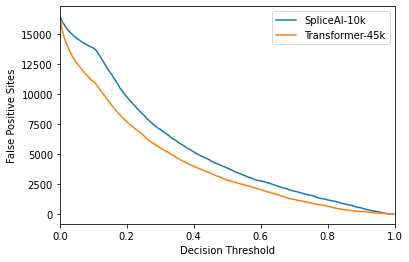

In [28]:
plt.plot(thresholds1[thresholds1<=1],fps1,label="SpliceAI-10k")
plt.plot(thresholds2[thresholds2<=1],fps2,label="Transformer-45k")
plt.legend()
plt.xlim(0,1)
plt.ylabel('False Positive Sites')
plt.xlabel('Decision Threshold')
plt.savefig('../Results/FPs_Decision_Threshold_disagreement_181023.png', dpi=300)
plt.show()

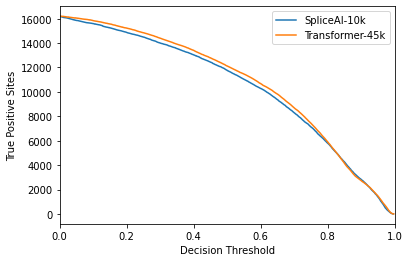

In [29]:
plt.plot(thresholds1[thresholds1<=1],tps1,label="SpliceAI-10k")
plt.plot(thresholds2[thresholds2<=1],tps2,label="Transformer-45k")
plt.legend()
plt.xlim(0,1)
plt.ylabel('True Positive Sites')
plt.xlabel('Decision Threshold')
plt.savefig('../Results/TPs_Decision_Threshold_disagreement_181023.png', dpi=300)
plt.show()

In [20]:
label = (df1_da.Y_true_acceptor).values
prob = (df1_da.Y_pred_acceptor).values
fps1 = []
tps1 = []
for t in tqdm(thresholds1[thresholds1<=1]):
    pred = (prob>=t).astype(int)
    cond = pred==1
    fps1.append(np.sum((1-label[cond])==pred[cond]))
    tps1.append(np.sum((label[cond])==pred[cond]))

label = (df1_da.Y_true_donor).values
prob = (df1_da.Y_pred_donor).values
fps3 = []
tps3 = []
for t in tqdm(thresholds1[thresholds1<=1]):
    pred = (prob>=t).astype(int)
    cond = pred==1
    fps3.append(np.sum((1-label[cond])==pred[cond]))
    tps3.append(np.sum((label[cond])==pred[cond]))

label = (df2_da.Y_true_acceptor).values
prob = (df2_da.Y_pred_acceptor).values
fps2 = []
tps2 = []
for t in tqdm(thresholds2[thresholds2<=1]):
    pred = (prob>=t).astype(int)
    cond = pred==1
    fps2.append(np.sum((1-label[cond])==pred[cond]))
    tps2.append(np.sum((label[cond])==pred[cond]))
    
label = (df2_da.Y_true_donor).values
prob = (df2_da.Y_pred_donor).values
fps4 = []
tps4 = []
for t in tqdm(thresholds2[thresholds2<=1]):
    pred = (prob>=t).astype(int)
    cond = pred==1
    fps4.append(np.sum((1-label[cond])==pred[cond]))
    tps4.append(np.sum((label[cond])==pred[cond]))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 10354/10354 [00:06<00:00, 1592.32it/s]


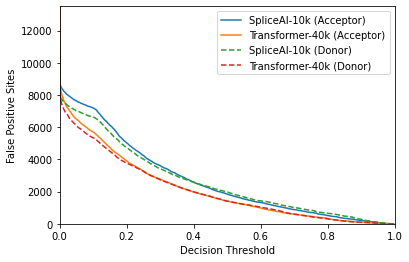

In [21]:
plt.plot(thresholds1[thresholds1<=1],fps1,label="SpliceAI-10k (Acceptor)")
plt.plot(thresholds2[thresholds2<=1],fps2,label="Transformer-40k (Acceptor)")
plt.plot(thresholds1[thresholds1<=1],fps3,ls='--',label="SpliceAI-10k (Donor)")

plt.plot(thresholds2[thresholds2<=1],fps4,ls='--',label="Transformer-40k (Donor)")
plt.legend()
plt.xlim(0,1)
plt.ylim(0,13500)
plt.ylabel('False Positive Sites')
plt.xlabel('Decision Threshold')
plt.savefig('../Results/FPs_Decision_Threshold_breakdown_disagreement_201022.png', dpi=300)
plt.show()

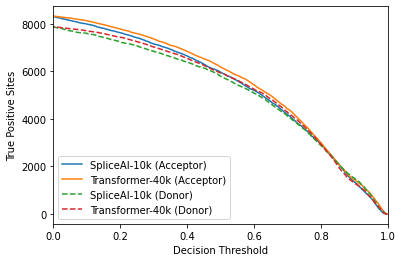

In [22]:
plt.plot(thresholds1[thresholds1<=1],tps1,label="SpliceAI-10k (Acceptor)")
plt.plot(thresholds2[thresholds2<=1],tps2,label="Transformer-40k (Acceptor)")
plt.plot(thresholds1[thresholds1<=1],tps3,ls='--',label="SpliceAI-10k (Donor)")

plt.plot(thresholds2[thresholds2<=1],tps4,ls='--',label="Transformer-40k (Donor)")
plt.legend()
plt.xlim(0,1)
plt.ylabel('True Positive Sites')
plt.xlabel('Decision Threshold')
plt.savefig('../Results/TPs_Decision_Threshold_breakdown_disagreement_201022.png', dpi=300)
plt.show()

In [23]:
df1_da2 = df1[df1['tvd']>=0.2]
df2_da2 = df2[df2['tvd']>=0.2]

In [24]:
from sklearn.utils import resample

In [38]:
res = []
for i in tqdm(range(1000)):
    idx = resample(np.arange(df2['Y_pred_acceptor'].shape[0]), stratify=df2['Y_true_acceptor']+2*df2['Y_true_donor'])
    x = average_precision_score(df2['Y_true_acceptor'].values[idx]+df2['Y_true_donor'].values[idx],df2['Y_pred_acceptor'].values[idx]+df2['Y_pred_donor'].values[idx])
    print(x)
    res.append(x)

  0%|                                                                                                     | 1/1000 [13:01<216:55:03, 781.68s/it]

0.9683811424306384


  0%|▏                                                                                                    | 2/1000 [26:05<217:06:48, 783.17s/it]

0.9677124294416316


  0%|▎                                                                                                    | 3/1000 [38:54<215:02:05, 776.45s/it]

0.9675694794737075


  0%|▍                                                                                                    | 4/1000 [51:50<214:44:44, 776.19s/it]

0.9675413656045138


  0%|▍                                                                                                  | 5/1000 [1:04:40<213:56:28, 774.06s/it]

0.9679328014595131


  1%|▌                                                                                                  | 6/1000 [1:17:12<211:37:44, 766.46s/it]

0.967987573416992


  1%|▋                                                                                                  | 7/1000 [1:29:53<210:59:48, 764.94s/it]

0.9675750998064141


  1%|▊                                                                                                  | 8/1000 [1:42:53<212:02:51, 769.53s/it]

0.9678194858634646


  1%|▉                                                                                                  | 9/1000 [1:55:43<211:53:07, 769.71s/it]

0.9678215263673001


  1%|▉                                                                                                 | 10/1000 [2:08:34<211:46:12, 770.07s/it]

0.9680392320552051


  1%|█                                                                                                 | 11/1000 [2:21:28<211:53:39, 771.30s/it]

0.9684983595439342


  1%|█▏                                                                                                | 12/1000 [2:34:17<211:29:04, 770.59s/it]

0.9672003079639165


  1%|█▎                                                                                                | 13/1000 [2:46:58<210:28:33, 767.69s/it]

0.9682953178424877


  1%|█▎                                                                                                | 14/1000 [2:59:53<210:54:04, 770.03s/it]

0.9678124254083923


  2%|█▍                                                                                                | 15/1000 [3:13:12<213:02:55, 778.66s/it]

0.968664129350706


  2%|█▌                                                                                                | 16/1000 [3:26:08<212:37:27, 777.89s/it]

0.9680871281472085


  2%|█▋                                                                                                | 17/1000 [3:39:22<213:43:34, 782.72s/it]

0.9682021431713654


  2%|█▊                                                                                                | 18/1000 [3:52:17<212:54:22, 780.51s/it]

0.9683141047979992


  2%|█▊                                                                                                | 19/1000 [4:05:24<213:10:46, 782.31s/it]

0.9679053163325126


  2%|█▉                                                                                                | 20/1000 [4:18:29<213:10:43, 783.11s/it]

0.9679967662843533


  2%|██                                                                                                | 21/1000 [4:31:13<211:24:18, 777.38s/it]

0.967831061993722


  2%|██▏                                                                                               | 22/1000 [4:44:18<211:48:41, 779.67s/it]

0.96816374262099


  2%|██▎                                                                                               | 23/1000 [4:57:25<212:09:55, 781.78s/it]

0.9688218653094178


  2%|██▎                                                                                               | 24/1000 [5:10:35<212:38:37, 784.34s/it]

0.9684818327453418


  2%|██▍                                                                                               | 25/1000 [5:24:15<215:20:38, 795.12s/it]

0.9687328432563898


  3%|██▌                                                                                               | 26/1000 [5:36:53<212:06:29, 783.97s/it]

0.9683986684306226


  3%|██▋                                                                                               | 27/1000 [5:49:40<210:29:07, 778.77s/it]

0.9679872814570156


  3%|██▋                                                                                               | 28/1000 [6:02:46<210:50:35, 780.90s/it]

0.9677629835308265


  3%|██▊                                                                                               | 29/1000 [6:15:45<210:27:51, 780.30s/it]

0.9680790974780735


  3%|██▉                                                                                               | 30/1000 [6:29:00<211:30:02, 784.95s/it]

0.967560436431769


  3%|███                                                                                               | 31/1000 [6:41:47<209:47:39, 779.42s/it]

0.9680831131792621


  3%|███▏                                                                                              | 32/1000 [6:54:28<208:06:51, 773.98s/it]

0.9684320584933418


  3%|███▏                                                                                              | 33/1000 [7:07:08<206:43:37, 769.62s/it]

0.9683821810951717


  3%|███▎                                                                                              | 34/1000 [7:19:40<205:07:30, 764.44s/it]

0.9679446536145727


  4%|███▍                                                                                              | 35/1000 [7:32:18<204:23:13, 762.48s/it]

0.9682452621122465


  4%|███▌                                                                                              | 36/1000 [7:45:05<204:32:00, 763.82s/it]

0.9682051787004953


  4%|███▋                                                                                              | 37/1000 [7:57:35<203:15:21, 759.84s/it]

0.9681391158531004


  4%|███▋                                                                                              | 38/1000 [8:10:01<201:56:32, 755.71s/it]

0.9678074583838863


  4%|███▊                                                                                              | 39/1000 [8:22:57<203:18:53, 761.64s/it]

0.9687030716757512


  4%|███▉                                                                                              | 40/1000 [8:35:19<201:30:11, 755.64s/it]

0.9679844421212961


  4%|████                                                                                              | 41/1000 [8:48:04<202:06:45, 758.71s/it]

0.9683392089548375


  4%|████                                                                                              | 42/1000 [9:00:48<202:17:20, 760.17s/it]

0.9681956746940871


  4%|████▏                                                                                             | 43/1000 [9:13:19<201:18:43, 757.29s/it]

0.9682274715089416


  4%|████▎                                                                                             | 44/1000 [9:26:11<202:18:44, 761.85s/it]

0.9681582572620292


  4%|████▍                                                                                             | 45/1000 [9:38:40<201:02:52, 757.88s/it]

0.9688354862298298


  5%|████▌                                                                                             | 46/1000 [9:52:39<207:19:03, 782.33s/it]

0.9678928750072672


  5%|████▌                                                                                            | 47/1000 [10:05:25<205:46:24, 777.32s/it]

0.968754575382159


  5%|████▋                                                                                            | 48/1000 [10:18:21<205:27:17, 776.93s/it]

0.968477629718207


  5%|████▊                                                                                            | 49/1000 [10:31:20<205:25:07, 777.61s/it]

0.9681502999880108


  5%|████▊                                                                                            | 50/1000 [10:43:54<203:21:50, 770.64s/it]

0.9685879600685682


  5%|████▉                                                                                            | 51/1000 [10:56:34<202:18:14, 767.43s/it]

0.9686768242391965


  5%|█████                                                                                            | 52/1000 [11:09:37<203:19:10, 772.10s/it]

0.96774317850399


  5%|█████▏                                                                                           | 53/1000 [11:22:43<204:12:43, 776.31s/it]

0.9676379710711474


  5%|█████▏                                                                                           | 54/1000 [11:35:25<202:51:26, 771.97s/it]

0.968188146337374


  6%|█████▎                                                                                           | 55/1000 [11:48:07<201:50:34, 768.92s/it]

0.9674894639448595


  6%|█████▍                                                                                           | 56/1000 [12:01:15<203:06:07, 774.54s/it]

0.9681662722143959


  6%|█████▌                                                                                           | 57/1000 [12:14:36<205:00:05, 782.61s/it]

0.9677752360340625


  6%|█████▋                                                                                           | 58/1000 [12:27:04<202:05:54, 772.35s/it]

0.9669798696954977


  6%|█████▋                                                                                           | 59/1000 [12:39:49<201:18:01, 770.12s/it]

0.968573607332546


  6%|█████▊                                                                                           | 60/1000 [12:53:01<202:44:05, 776.43s/it]

0.9686251744114089


  6%|█████▉                                                                                           | 61/1000 [13:06:03<202:57:47, 778.13s/it]

0.9677622557155409


  6%|██████                                                                                           | 62/1000 [13:19:01<202:44:43, 778.13s/it]

0.9682097062021567


  6%|██████                                                                                           | 63/1000 [13:31:54<202:07:57, 776.60s/it]

0.9681585648945077


  6%|██████▏                                                                                          | 64/1000 [13:44:26<200:02:37, 769.40s/it]

0.9676070929152879


  6%|██████▎                                                                                          | 65/1000 [13:57:11<199:26:11, 767.88s/it]

0.9682598927055719


  7%|██████▍                                                                                          | 66/1000 [14:09:56<199:02:05, 767.16s/it]

0.9674872103996278


  7%|██████▍                                                                                          | 67/1000 [14:22:55<199:41:44, 770.53s/it]

0.9677694618307094


  7%|██████▌                                                                                          | 68/1000 [14:35:40<199:03:17, 768.88s/it]

0.9684789585336124


  7%|██████▋                                                                                          | 69/1000 [14:48:58<201:05:32, 777.59s/it]

0.9682517683016658


  7%|██████▊                                                                                          | 70/1000 [15:01:55<200:49:41, 777.40s/it]

0.9685469789145353


  7%|██████▉                                                                                          | 71/1000 [15:15:14<202:19:50, 784.06s/it]

0.9685247543613217


  7%|██████▉                                                                                          | 72/1000 [15:28:02<200:51:05, 779.17s/it]

0.968230217765623


  7%|███████                                                                                          | 73/1000 [15:41:10<201:19:50, 781.87s/it]

0.9681866879709803


  7%|███████▏                                                                                         | 74/1000 [15:53:55<199:47:46, 776.75s/it]

0.9693011125996658


  8%|███████▎                                                                                         | 75/1000 [16:06:50<199:29:12, 776.38s/it]

0.96832226192873


  8%|███████▎                                                                                         | 76/1000 [16:20:02<200:26:42, 780.96s/it]

0.9675543361301009


  8%|███████▍                                                                                         | 77/1000 [16:32:50<199:13:31, 777.04s/it]

0.9688643407984846


  8%|███████▌                                                                                         | 78/1000 [16:45:39<198:25:03, 774.73s/it]

0.9680104846851395


  8%|███████▋                                                                                         | 79/1000 [16:58:42<198:50:05, 777.20s/it]

0.9673999945527219


  8%|███████▊                                                                                         | 80/1000 [17:11:38<198:28:51, 776.66s/it]

0.9689126073713661


  8%|███████▊                                                                                         | 81/1000 [17:24:27<197:41:23, 774.41s/it]

0.9676924744653335


  8%|███████▉                                                                                         | 82/1000 [17:36:58<195:42:15, 767.47s/it]

0.9687612884905015


  8%|████████                                                                                         | 83/1000 [17:49:28<194:07:33, 762.11s/it]

0.9685531821728544


  8%|████████▏                                                                                        | 84/1000 [18:02:15<194:20:38, 763.80s/it]

0.9686227904107584


  8%|████████▏                                                                                        | 85/1000 [18:15:14<195:17:16, 768.35s/it]

0.9679040199987993


  9%|████████▎                                                                                        | 86/1000 [18:28:07<195:23:22, 769.59s/it]

0.9676043096307512


  9%|████████▍                                                                                        | 87/1000 [18:40:59<195:21:02, 770.28s/it]

0.9685981744236494


  9%|████████▌                                                                                        | 88/1000 [18:53:37<194:14:09, 766.72s/it]

0.9683452033949246


  9%|████████▋                                                                                        | 89/1000 [19:06:18<193:32:41, 764.83s/it]

0.9687550839260636


  9%|████████▋                                                                                        | 90/1000 [19:19:23<194:51:56, 770.90s/it]

0.9691287354924663


  9%|████████▊                                                                                        | 91/1000 [19:32:27<195:38:44, 774.83s/it]

0.9682660581171731


  9%|████████▉                                                                                        | 92/1000 [19:45:32<196:12:46, 777.94s/it]

0.9683159250717184


  9%|█████████                                                                                        | 93/1000 [19:58:06<194:12:51, 770.86s/it]

0.9685063481935585


  9%|█████████                                                                                        | 94/1000 [20:10:31<192:03:32, 763.15s/it]

0.9677087002106567


 10%|█████████▏                                                                                       | 95/1000 [20:23:23<192:29:58, 765.74s/it]

0.968421957497236


 10%|█████████▎                                                                                       | 96/1000 [20:36:11<192:24:59, 766.26s/it]

0.9680034396826783


 10%|█████████▍                                                                                       | 97/1000 [20:48:47<191:29:11, 763.40s/it]

0.9670948508792525


 10%|█████████▌                                                                                       | 98/1000 [21:01:19<190:24:08, 759.92s/it]

0.9689572784802495


 10%|█████████▌                                                                                       | 99/1000 [21:14:14<191:16:55, 764.28s/it]

0.9679711011575889


 10%|█████████▌                                                                                      | 100/1000 [21:27:03<191:25:20, 765.69s/it]

0.9674915699329893


 10%|█████████▋                                                                                      | 101/1000 [21:39:35<190:13:07, 761.72s/it]

0.9678514584623056


 10%|█████████▋                                                                                      | 101/1000 [21:43:50<193:25:32, 774.56s/it]


KeyboardInterrupt: 

PR_AUC 95% confidence interval:  [0.96730015 0.96893494]


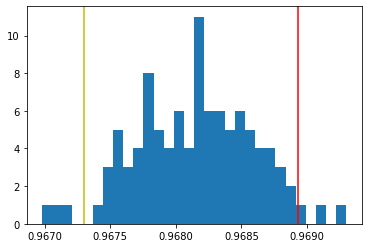

In [53]:
plt.hist(res,bins=30)
plt.axvline(x=np.percentile(res,[2.5]), ymin=0, ymax=1,label='2.5th percentile',c='y')
plt.axvline(x=np.percentile(res,[97.5]), ymin=0, ymax=1,label='97.5th percentile',c='r')
conf_interval = np.percentile(res,[2.5,97.5])

# Print the interval
print("PR_AUC 95% confidence interval: ",conf_interval)
plt.show()